# Filtering and business cycles

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from dateutil.relativedelta import relativedelta

## 0) Load the Data

*In this exercise you need to replicate some business cycle data work that you studied in class
using any programming language of your choice. You are also encouraged to work with your
classmates in completing these coding exercises. In class, I will ask a few of you to present
your results, so try your best to make your codes and plots are as neat as possible.
Download quarterly data for US real GDP, consumption, and investment.1 Take logs of
the data and make sure that your data is seasonally adjusted.*

As a first step, we imported the datasets we are interested in via the. `fredapi` library. Specifically, we initialized a fred object by providing our key as input. Then, using the `get_series` function with the codes of the datasets, we downloaded and saved them in different pandas series.

In [4]:
from fredapi import Fred
fred = Fred(api_key = '3c333fd92c7d3df79f55af2ee72f13bf')

start_data = '1960-01-01'
end_data = '2023-03-31'

def get_data(code, start_data = start_data, end_data = end_data):
    return fred.get_series(code, start_data, end_data)

gdp = get_data('GDPC1')
cons = get_data('PCECC96')
inv = get_data('GPDIC1')
rec = get_data('USRECQ')

Name the Series: 

In [5]:
gdp.name = 'gdp'
cons.name = 'cons'
inv.name = 'inv'
rec.name = 'rec'

Apply a log transformation: 

In [6]:
gdp = np.log(gdp)
cons = np.log(cons)
inv = np.log(inv)

Join all the series in one dataframe: 

In [7]:
cols = [gdp, cons, inv,rec]
df = pd.concat(cols, axis = 1)
df = df.assign(Date = df.index.to_pydatetime()) #ensures that the Date column
                                                #is of the correct datetime type

Before starting with the solution of the exercise, we first prepared all the metrics that we will need later, and saved them in a single DataFrame.

## 0.1) Linear trend line

We calculated the linear trend and fluctuations from the trend following these steps: 
1) Convert the dates to numeric type.
2) Regressed the gdp on the dates.
3) Created a function using the intercept and coefficient found in step 2).
4) Used the function from step three on the dates in numeric format to create the trend line. 

In [12]:
converted_date = df.index.values.astype("float64")
x = np.polyfit(converted_date, df.gdp, 1) #Returns least squares coefficients
z = np.poly1d(x) #create a polynomial function using the above coefficients
lin_trend = pd.Series(z(converted_date), index = df.index)

fluctuations = df.gdp - lin_trend

df = df.assign(lin_trend = lin_trend, lin_fluctuations = fluctuations)

## 0.2) HP Filter

We used the `hpfilter` function from the `statsmodel` library to decompose gdp (with different values of lambda), consumption, and investment. 

### GDP

In [13]:
import statsmodels.api as sm
gdp_cycle_1600, gdp_trend_1600 = sm.tsa.filters.hpfilter(df.gdp, 1600)

df = df.assign(gdp_trend_1600 = gdp_trend_1600, gdp_cycle_1600 = gdp_cycle_1600)

In [14]:
gdp_cycle_800, gdp_trend_800 = sm.tsa.filters.hpfilter(df.gdp, 800)

df = df.assign(gdp_trend_800 = gdp_trend_800, gdp_cycle_800 = gdp_cycle_800)


In [15]:
gdp_cycle_400, gdp_trend_400 = sm.tsa.filters.hpfilter(df.gdp, 400)

df = df.assign(gdp_trend_400 = gdp_trend_400, gdp_cycle_400 = gdp_cycle_400)


### Consumptions and Investments

In [16]:
cons_cycle, cons_tred = sm.tsa.filters.hpfilter(df.cons, 1600)
inv_cycle, inv_trend = sm.tsa.filters.hpfilter(df.inv, 1600)

df = df.assign(cons_trend = cons_tred, cons_cycle = cons_cycle, 
              inv_trend = inv_trend, inv_cycle = inv_cycle)


## 0.3) DF with only data since 2000

To make it easier to analyze the data after the year 2000, as required in some points of the exercise, we extracted this portion of the data from the original dataframe and saved it in a new one.

In [20]:
df_2000 = df.loc[df.index >= '2000-01-01', ]


## 0.3) Define the style of the graph

To plot graphs with a consistent style, we used the `style.use` function of the `matplolib` library, which allows us to import a file that modifies the default graph parameters. We also defined some functions to add some aesthetics. 

In [17]:
plt.style.use('mystyle.mplstyle')

def make_a_line():
    ax.plot([0.12, .9],              # Set width of line
        [1.05, 1.05],                # Set height of line
        transform=fig.transFigure,   # Set location relative to plot
        clip_on=False, 
        color='#E3120B', 
        linewidth=.6)
    
    
def make_a_rec():
    ax.add_patch(plt.Rectangle((0.12,1.05),            # Set location of rectangle by lower left corder
                           0.04,                       # Width of rectangle
                           -0.02,                      # Height of rectangle. Negative so it goes down.
                           facecolor='#E3120B', 
                           transform=fig.transFigure, 
                           clip_on=False, 
                           linewidth = 0))
    
    
def make_title(text):
    ax.text(x=0.12, y=0.98, s=text, 
            transform=fig.transFigure, ha='left', 
            fontsize=13, weight='bold', alpha=.8)
    
    
def make_description(text):
    ax.text(x=0.12, y=0.93, s=text, 
            transform=fig.transFigure, ha='left', 
            fontsize=11, alpha=.8)

# 1) US GDP and recession periods

For the first graph we plotted the log real gdp and then we added a grey area in the quarters corresponding to a recession period. In order to add the grey rectangles we use the function axvspan, that does exactly this and that needs as input a start and an end value from the x axis. Given that we have a time series, we first extracted all the recession quarters, providing the first day of the quarter as the beginning value, and the last day of the quarter as the end value.

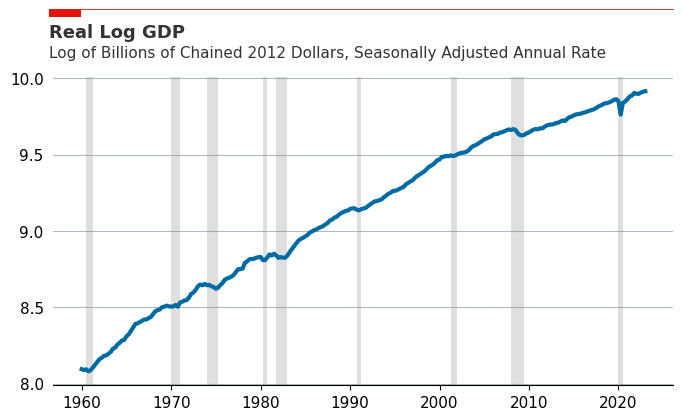

In [18]:
fig, ax = plt.subplots()

ax.plot(df.Date, df.gdp, zorder = 2)

ax.yaxis.set_ticks(np.arange(8,10.1,0.5))

make_a_line()
make_a_rec()
make_title('Real Log GDP')
make_description("Log of Billions of Chained 2012 Dollars, Seasonally Adjusted Annual Rate")

recession = df.loc[df["rec"] == 1, 'Date']
for day in recession: 
    ax.axvspan(day, day + relativedelta(months =+ 3), color="grey", alpha = 0.25, lw=0, zorder = 1)


# 2) Add the trendline

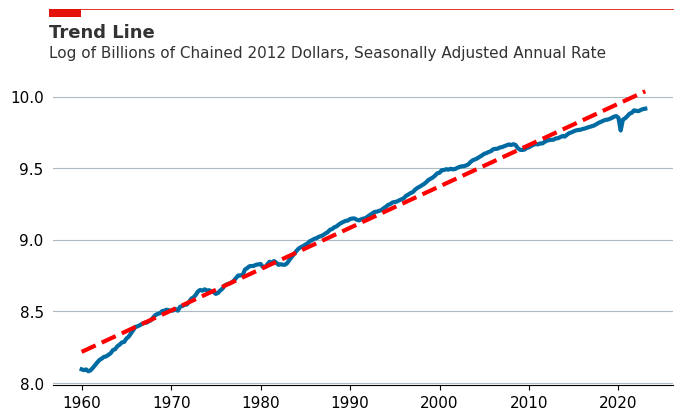

In [49]:
fig, ax = plt.subplots()

ax.plot(df.Date, df.gdp, zorder = 2)
ax.plot(df.Date, df.lin_trend, 'r--')
ax.yaxis.set_ticks(np.arange(8,10.1,0.5))

make_a_line()
make_a_rec()
make_title('Trend Line')
make_description("Log of Billions of Chained 2012 Dollars, Seasonally Adjusted Annual Rate")

## 2.1) Since 2000

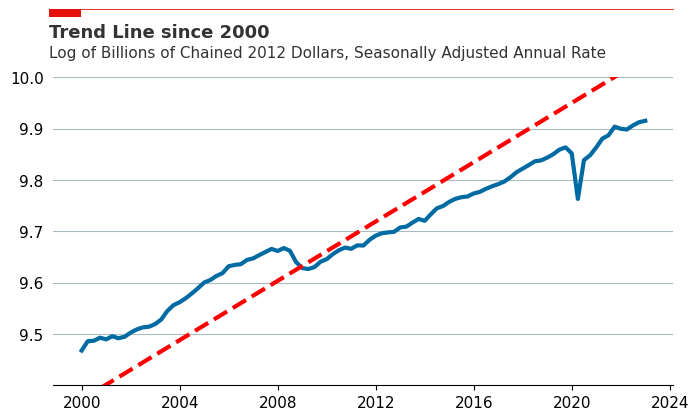

In [21]:
fig, ax = plt.subplots()

ax.plot(df_2000.Date, df_2000.gdp, zorder = 2)
ax.plot(df_2000.Date, df_2000.lin_trend, 'r--')
ax.yaxis.set_ticks(np.arange(9.5,10.1,0.1))

plt.ylim(9.4,10)

make_a_line()
make_a_rec()
make_title('Trend Line since 2000')
make_description("Log of Billions of Chained 2012 Dollars, Seasonally Adjusted Annual Rate")

*Following from what we did in previous
classes, how would you interpret the performance of the US economy since the early
2000s?*

We can see from the graph that prior to the financial crisis the GDP of the United States was above trend. After the collapse due to the crisis, however, the gdp no longer came close to the pre-crisis trend. 

# 3) Show the fluctuations

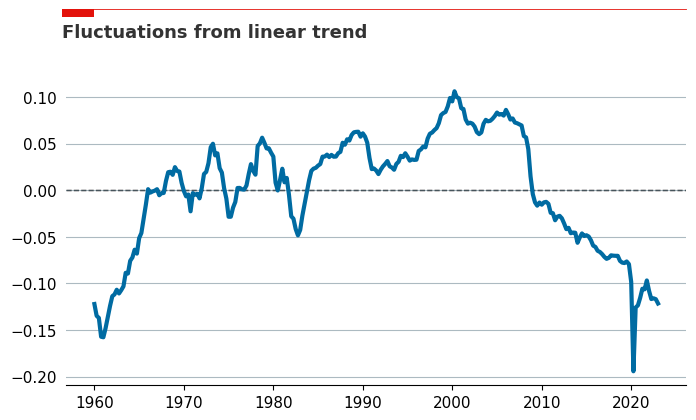

In [53]:
fig, ax = plt.subplots()

ax.plot(df.Date, df.lin_fluctuations, zorder = 2)


plt.axhline(y=0, color = 'black', linestyle= 'dashed', lw = 1, zorder=1)

make_a_line()
make_a_rec()
make_title('Fluctuations from linear trend')

## 3.1) Since 2000

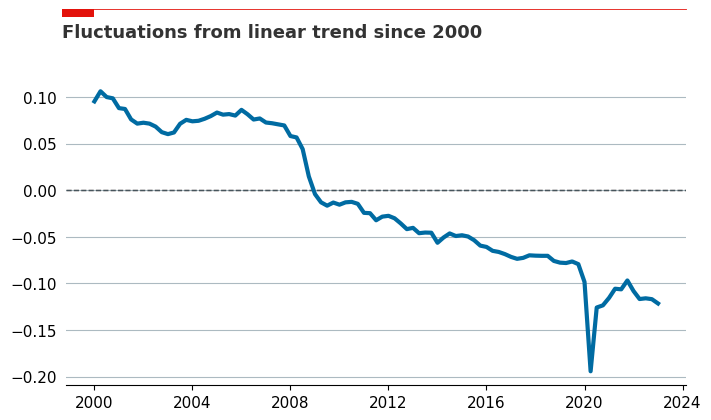

In [55]:
fig, ax = plt.subplots()

ax.plot(df_2000.Date, df_2000.lin_fluctuations, zorder = 2)


plt.axhline(y=0, color = 'black', linestyle= 'dashed', lw = 1, zorder=1)

make_a_line()
make_a_rec()
make_title('Fluctuations from linear trend since 2000')

# 4) HP Filter

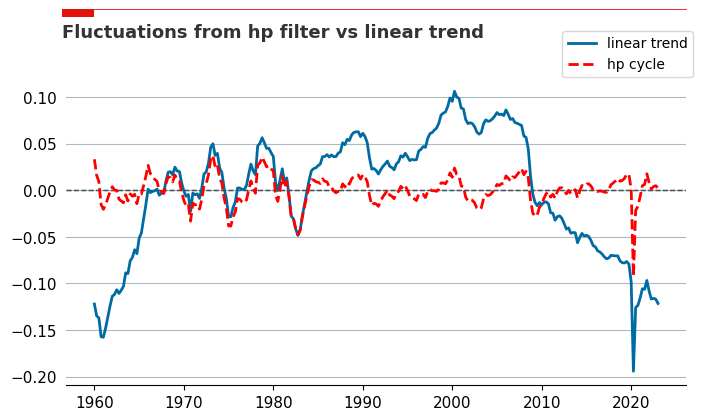

In [22]:
fig, ax = plt.subplots()

ax.plot(df.Date, df.lin_fluctuations, zorder = 2, lw = 2, label = 'linear trend')
ax.plot(df.Date, df.gdp_cycle_1600,  'r--', zorder = 2, lw = 2, label = 'hp cycle')


plt.axhline(y=0, color = 'black', linestyle= 'dashed', lw = 1, zorder=1)
ax.legend(loc = (0.80,1))
make_a_line()
make_a_rec()
make_title('Fluctuations from hp filter vs linear trend')

## 4.1) Since 2000

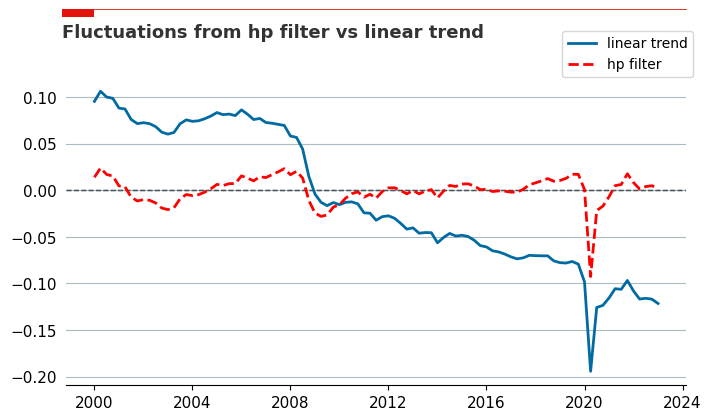

In [23]:
fig, ax = plt.subplots()

ax.plot(df_2000.Date, df_2000.lin_fluctuations, zorder = 2, lw = 2, label = 'linear trend')
ax.plot(df_2000.Date, df_2000.gdp_cycle_1600,  'r--', zorder = 2, lw = 2, label = 'hp filter')

ax.legend(loc = (0.80,1))
plt.axhline(y=0, color = 'black', linestyle= 'dashed', lw = 1, zorder=1)

make_a_line()
make_a_rec()
make_title('Fluctuations from hp filter vs linear trend')

The difference in the cyclical component derived through the HP filter compared to the deviations from the linear trend, is due to the fact that the HP filter takes into account the smoothness of the trend with respect to the actual values, thus coming closer to them than does a linear trend. For this reason for the period under analysis the cyclical component is much closer to zero than linear fluctuations. 

# 5) Consumption and investment

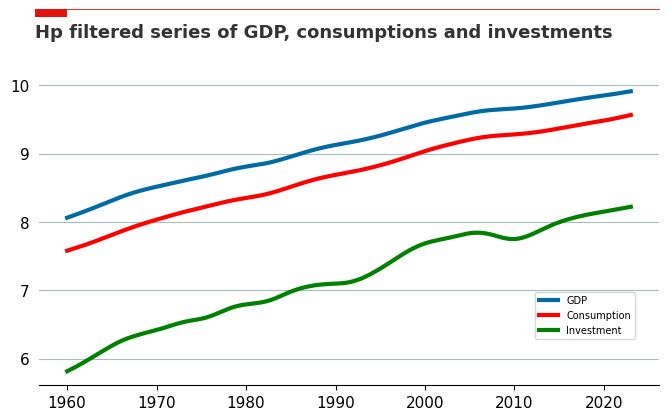

In [28]:
fig, ax = plt.subplots()

ax.plot(df.Date, df.gdp_trend_1600, zorder = 2, label = 'GDP')
ax.plot(df.Date, df.cons_trend, color = 'red', label = 'Consumption')
ax.plot(df.Date, df.inv_trend, color = 'green', label = 'Investment')

ax.legend(loc = (0.80,0.15), fontsize = 7)
make_a_line()
make_a_rec()
make_title('Hp filtered series of GDP, consumptions and investments')

Consumption more closely follows the trend of gdp than investment does. 

# 6) Different level of lambda

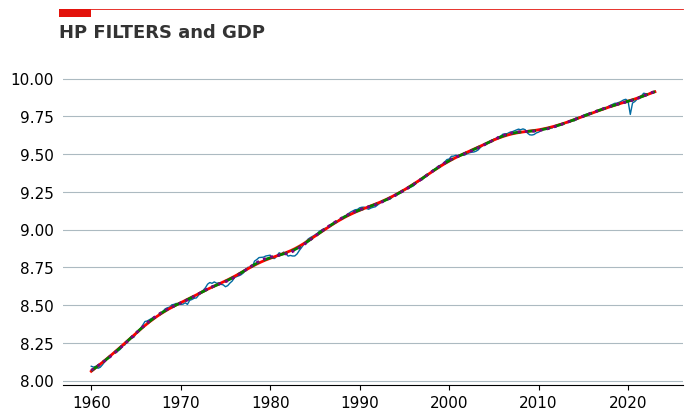

In [93]:
fig, ax = plt.subplots()

ax.plot(df.Date, df.gdp, linewidth = 1)
ax.plot(df.Date, df.gdp_trend_1600, color='red' , linewidth = 2, linestyle = 'solid')
ax.plot(df.Date, df.gdp_trend_800, color = 'green', linewidth = 2, linestyle = 'dashed')
ax.plot(df.Date, df.gdp_trend_400, color = 'purple', linewidth = 2, linestyle ='dotted' )


make_a_line()
make_a_rec()
make_title('HP FILTERS and GDP')

From this graph it is impossible to see the trends of gdp calculated with different values of lambda

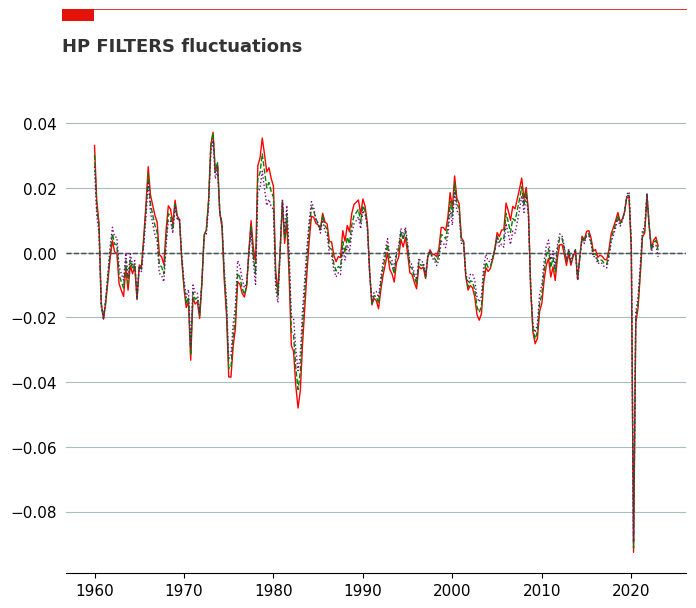

In [94]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(df.Date, df.gdp_cycle_1600, color = 'red', linewidth = 1, linestyle = 'solid')
ax.plot(df.Date, df.gdp_cycle_800, color = 'green', linewidth = 1, linestyle = 'dashed')
ax.plot(df.Date, df.gdp_cycle_400, color = 'purple', linewidth = 1, linestyle ='dotted' )

    
plt.axhline(y=0, color = 'black', linestyle= 'dashed', lw = 1, zorder=1)

make_a_line()
make_a_rec()
make_title('HP FILTERS fluctuations')

# 6.1) After 2000

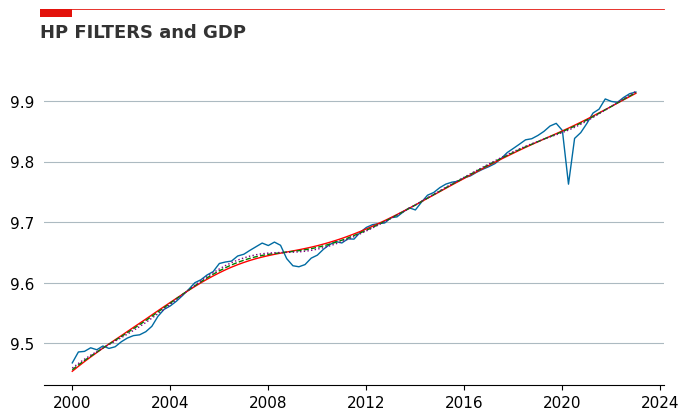

In [95]:
fig, ax = plt.subplots()

ax.plot(df_2000.Date, df_2000.gdp, linewidth = 1)
ax.plot(df_2000.Date, df_2000.gdp_trend_1600, color='red' , linewidth = 1, linestyle = 'solid')
ax.plot(df_2000.Date, df_2000.gdp_trend_800, color = 'green', linewidth = 1, linestyle = 'dashed')
ax.plot(df_2000.Date, df_2000.gdp_trend_400, color = 'purple', linewidth = 1, linestyle ='dotted' )


make_a_line()
make_a_rec()
make_title('HP FILTERS and GDP')

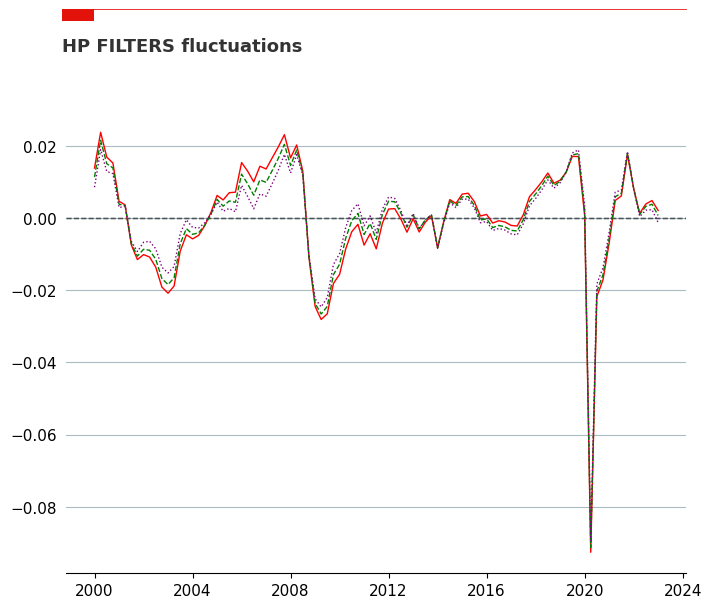

In [65]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(df_2000.Date, df_2000.gdp_cycle_1600, color = 'red', linewidth = 1, linestyle = 'solid')
ax.plot(df_2000.Date, df_2000.gdp_cycle_800, color = 'green', linewidth = 1, linestyle = 'dashed')
ax.plot(df_2000.Date, df_2000.gdp_cycle_400, color = 'purple', linewidth = 1, linestyle ='dotted' )

    
plt.axhline(y=0, color = 'black', linestyle= 'dashed', lw = 1, zorder=1)

make_a_line()
make_a_rec()
make_title('HP FILTERS fluctuations')

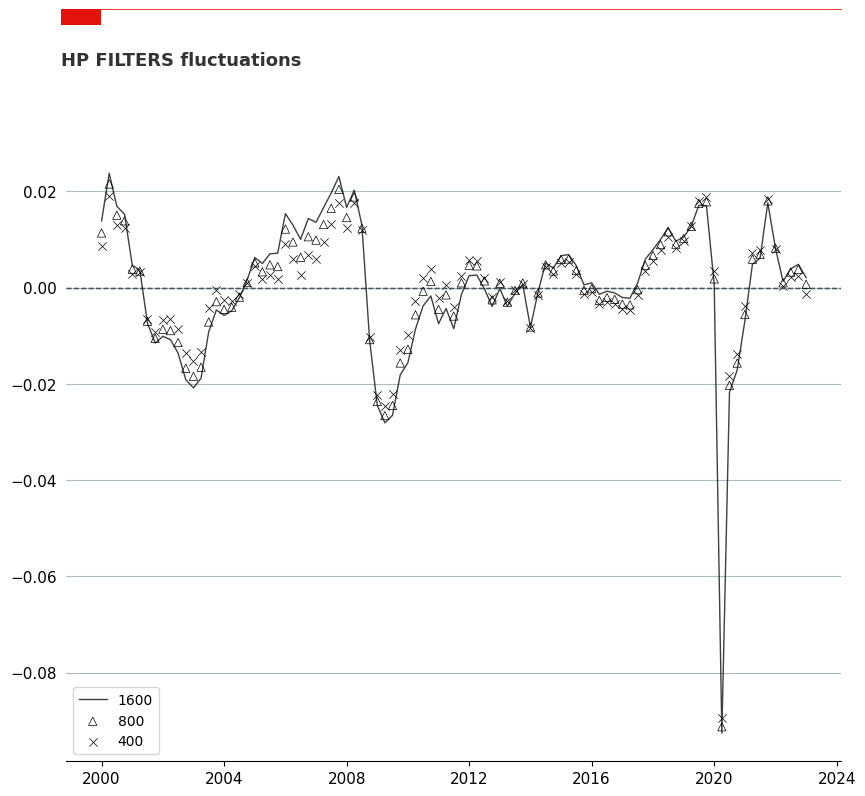

In [51]:
fig, ax = plt.subplots(figsize = (10, 8))

ax.plot(df_2000.Date, df_2000.gdp_cycle_1600, color = 'black', alpha = 0.75, 
        linewidth = 1, linestyle = 'solid', zorder = 3, label = '1600')

ax.scatter(df_2000.Date, df_2000.gdp_cycle_800, color = 'black', marker = '^', 
           zorder = 2, facecolor = 'none', linewidths= 0.5, label = '800')

ax.scatter(df_2000.Date, df_2000.gdp_cycle_400, color = 'black', marker = 'x', 
           zorder = 1, linewidths= 0.5, label = '400')

ax.legend()

    
plt.axhline(y=0, color = 'black', linestyle= 'dashed', lw = 1, zorder=1)

make_a_line()
make_a_rec()
make_title('HP FILTERS fluctuations')